In [27]:
import trackhhl.toy.simple_generator as toy
import trackhhl.event_model.q_event_model as em
import numpy as np
import itertools
import copy
import dimod
import psutil
import time
import tracemalloc
import matplotlib.pyplot as plt
import win32com.client  # For interacting with COM objects




In [28]:
def generate_hamiltonian(event, params):
    lambda_val = params.get('lambda')
    alpha = params.get('alpha')
    beta = params.get('beta')

    modules = copy.deepcopy(event.modules)
    modules.sort(key=lambda a: a.z)

    segments = [em.segment(from_hit, to_hit) for idx in range(len(modules) - 1) for from_hit, to_hit in itertools.product(modules[idx].hits, modules[idx + 1].hits)]
    N = len(segments)
    A = np.zeros((N, N))
    A_ang = np.zeros((N, N))
    A_bif = np.zeros((N, N))
    
    b = np.zeros(N)

    s_ab = np.zeros((N, N))
    for i, seg_i in enumerate(segments):
        for j, seg_j in enumerate(segments):
            s_ab[i, j] = int(seg_i.from_hit.module_id == 1 and seg_j.to_hit.module_id == 1)
    A_inh = np.zeros((N, N))

    for i, seg_i in enumerate(segments):
        for j, seg_j in enumerate(segments):
            if i != j:
                vect_i = seg_i.to_vect()
                vect_j = seg_j.to_vect()
                cosine = np.dot(vect_i, vect_j) / (np.linalg.norm(vect_i) * np.linalg.norm(vect_j))

                eps = 1e-9

                if np.abs(cosine - 1) < eps:
                    A_ang[i, j] = 1

                if (seg_i.from_hit == seg_j.from_hit) and (seg_i.to_hit != seg_j.to_hit):
                    A_bif[i, j] = -alpha

                if (seg_i.from_hit != seg_j.from_hit) and (seg_i.to_hit == seg_j.to_hit):
                    A_bif[i, j] = -alpha

                A_inh[i, j] = s_ab[i, j] * s_ab[j, i] * beta

    # Compute the final expression
    A = -1 * (A_ang + A_bif + A_inh)

    components = {'A_ang': -A_ang, 'A_bif': -A_bif, 'A_inh': -A_inh}

    return A, b, components, segments


In [29]:
def generate_hamiltonian_optimized(event, params):
    lambda_val = params.get('lambda')
    alpha = params.get('alpha')
    beta = params.get('beta')

    modules = sorted(event.modules, key=lambda module: module.z)

    segments = [
        em.segment(from_hit, to_hit)
        for idx in range(len(modules) - 1)
        for from_hit, to_hit in itertools.product(modules[idx].hits, modules[idx + 1].hits)
    ]

    N = len(segments)  

    # Initialize sparse block matrices for efficiency
    A_ang_blocks = []
    A_bif_blocks = []
    A_inh_blocks = []
    b = np.zeros(N)

    # Total Hamiltonian into smaller blocks for better memory usage
    block_size = 500  
    num_blocks = (N + block_size - 1) // block_size  

    for block_idx in range(num_blocks):
        start_idx = block_idx * block_size
        end_idx = min(start_idx + block_size, N)
        A_ang_block = lil_matrix((end_idx - start_idx, end_idx - start_idx), dtype=np.float32)
        A_bif_block = lil_matrix((end_idx - start_idx, end_idx - start_idx), dtype=np.float32)
        A_inh_block = lil_matrix((end_idx - start_idx, end_idx - start_idx), dtype=np.float32)

        for i in range(start_idx, end_idx):
            seg_i = segments[i]
            vect_i = seg_i.to_vect()
            norm_i = np.linalg.norm(vect_i)

            for j in range(i + 1, end_idx):  #
                seg_j = segments[j]
                vect_j = seg_j.to_vect()
                norm_j = np.linalg.norm(vect_j)

                cosine = np.dot(vect_i, vect_j) / (norm_i * norm_j)
                if np.abs(cosine - 1) < 1e-9:
                    A_ang_block[i - start_idx, j - start_idx] = 1
                    A_ang_block[j - start_idx, i - start_idx] = 1  # Symmetry with positive sign

                if seg_i.from_hit == seg_j.from_hit and seg_i.to_hit != seg_j.to_hit:
                    A_bif_block[i - start_idx, j - start_idx] = -alpha
                    A_bif_block[j - start_idx, i - start_idx] = -alpha  # Symmetry with negative sign

                if seg_i.from_hit != seg_j.from_hit and seg_i.to_hit == seg_j.to_hit:
                    A_bif_block[i - start_idx, j - start_idx] = -alpha
                    A_bif_block[j - start_idx, i - start_idx] = -alpha  # Symmetry with negative sign

                s_ab = int(seg_i.from_hit.module_id == 1 and seg_j.to_hit.module_id == 1)
                if s_ab > 0:
                    A_inh_block[i - start_idx, j - start_idx] = beta * s_ab * s_ab
                    A_inh_block[j - start_idx, i - start_idx] = beta * s_ab * s_ab  # Symmetry with positive sign

        A_ang_blocks.append(A_ang_block)
        A_bif_blocks.append(A_bif_block)
        A_inh_blocks.append(A_inh_block)

    A_ang = block_diag(A_ang_blocks, format='csc')
    A_bif = block_diag(A_bif_blocks, format='csc')
    A_inh = block_diag(A_inh_blocks, format='csc')

    A = -1 * (A_ang + A_bif + A_inh)

    return A, b, segments


Testing with N_PARTICLES = 20...
Optimized: Time = 32.4508s, Peak Memory = 6.65 MiB
Non-Optimized: Time = 289.8492s, Peak Memory = 156.63 MiB
Testing with N_PARTICLES = 40...
Optimized: Time = 117.3469s, Peak Memory = 27.01 MiB
Non-Optimized: Time = 4590.8227s, Peak Memory = 2500.94 MiB
Testing with N_PARTICLES = 60...
Optimized: Time = 271.4549s, Peak Memory = 78.83 MiB
Non-Optimized: Time = 23297.1761s, Peak Memory = 12658.11 MiB
Testing with N_PARTICLES = 80...
Optimized: Time = 498.9506s, Peak Memory = 171.14 MiB
Non-Optimized failed with MemoryError at N_PARTICLES = 80
Testing with N_PARTICLES = 100...
Optimized: Time = 878.8516s, Peak Memory = 15002.91 MiB
Non-Optimized failed with MemoryError at N_PARTICLES = 100
Testing with N_PARTICLES = 120...
Optimized: Time = 1214.3041s, Peak Memory = 24418.47 MiB
Non-Optimized failed with MemoryError at N_PARTICLES = 120
Testing with N_PARTICLES = 140...
Optimized: Time = 1713.1203s, Peak Memory = 26125.32 MiB
Non-Optimized failed with Mem

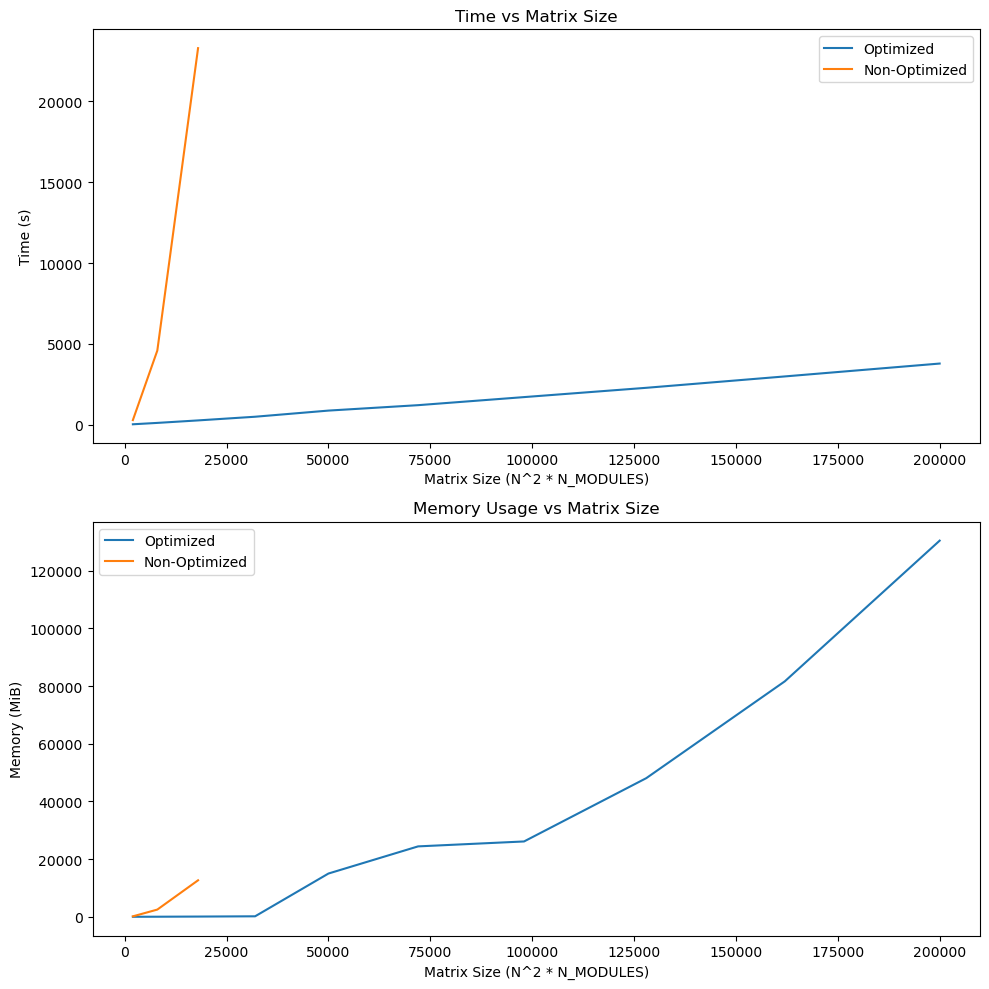

In [34]:
import numpy as np
import time
import tracemalloc
import matplotlib.pyplot as plt
import itertools
import copy
from scipy.sparse import block_diag

# Import your required modules (assumed to already be defined)
import trackhhl.toy.simple_generator as toy
import trackhhl.event_model.q_event_model as em

# Parameters and setup
N_MODULES = 5
LX = float("+inf")
LY = float("+inf")
Z_SPACING = 1.0

detector = toy.SimpleDetectorGeometry(
    module_id=list(range(N_MODULES)),
    lx=[LX] * N_MODULES,
    ly=[LY] * N_MODULES,
    z=[i + Z_SPACING for i in range(N_MODULES)]
)

generator = toy.SimpleGenerator(
    detector_geometry=detector,
    theta_max=np.pi / 6
)

params = {
    'alpha': 1.0,
    'beta': 1.0,
    'lambda': 100.0
}

# List of particle sizes to test (will result in different matrix sizes)
particle_counts = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]

# Functions to compare
functions = {
    "Optimized": generate_hamiltonian_optimized,
    "Non-Optimized": generate_hamiltonian
}

# Storage for time and memory results
time_results = {name: [] for name in functions}
memory_results = {name: [] for name in functions}

def measure_performance(func, event, params):
    """Helper function to measure time and memory usage of matrix generation."""
    # Start tracking memory with tracemalloc
    tracemalloc.start()

    # Time tracking
    start_time = time.time()

    # Execute the function
    func(event, params)

    # Stop time tracking
    elapsed_time = time.time() - start_time

    # Capture memory statistics
    current, peak = tracemalloc.get_traced_memory()

    # Stop tracemalloc and free memory
    tracemalloc.stop()

    # Return elapsed time and peak memory usage in MiB
    return elapsed_time, peak / (1024 * 1024)  # Convert from bytes to MiB

# Main loop to test different particle counts
for N_PARTICLES in particle_counts:
    print(f"Testing with N_PARTICLES = {N_PARTICLES}...")

    # Generate the event for this number of particles
    event = generator.generate_event(N_PARTICLES)
    
    for func_name, func in functions.items():
        try:
            elapsed_time, peak_mem = measure_performance(func, event, params)
            time_results[func_name].append(elapsed_time)
            memory_results[func_name].append(peak_mem)
            print(f"{func_name}: Time = {elapsed_time:.4f}s, Peak Memory = {peak_mem:.2f} MiB")
        
        except MemoryError:
            # If a memory error occurs, still record the result as 'inf' for memory and time
            time_results[func_name].append(float('inf'))
            memory_results[func_name].append(float('inf'))
            print(f"{func_name} failed with MemoryError at N_PARTICLES = {N_PARTICLES}")
            continue

# Plot the results
def plot_results():
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))

    # Time plot
    ax[0].set_title("Time vs Matrix Size")
    for func_name in time_results:
        ax[0].plot([N**2 * N_MODULES for N in particle_counts], time_results[func_name], label=func_name)
    ax[0].set_xlabel("Matrix Size (N^2 * N_MODULES)")
    ax[0].set_ylabel("Time (s)")
    ax[0].legend()

    # Memory plot
    ax[1].set_title("Memory Usage vs Matrix Size")
    for func_name in memory_results:
        ax[1].plot([N**2 * N_MODULES for N in particle_counts], memory_results[func_name], label=func_name)
    ax[1].set_xlabel("Matrix Size (N^2 * N_MODULES)")
    ax[1].set_ylabel("Memory (MiB)")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

plot_results()



Testing with input size: 10
Testing with input size: 20
Testing with input size: 30
Testing with input size: 40
Testing with input size: 50
Testing with input size: 60
Testing with input size: 70
Testing with input size: 80
Testing with input size: 90
Testing with input size: 100


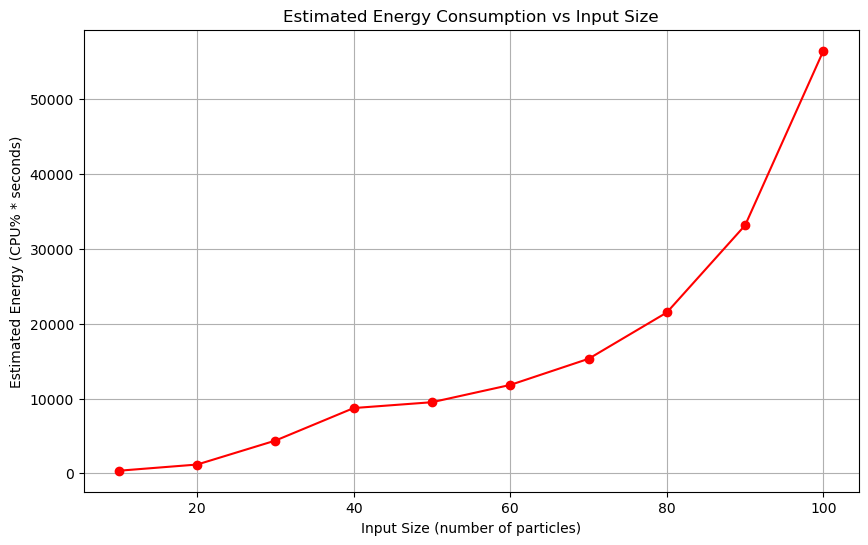

In [24]:
import numpy as np
import time
import psutil
import threading
import matplotlib.pyplot as plt

# Define the CPU usage measurement function
def measure_cpu_usage(interval, cpu_usage_list, stop_event):
    while not stop_event.is_set():
        # Get the CPU usage percentage
        cpu_percent = psutil.cpu_percent(interval=None)
        cpu_usage_list.append(cpu_percent)
        time.sleep(interval)

# Initialize lists to store results
input_sizes = []
estimated_energies = []

# Define the range of input sizes (adjust as needed)
start_size = 10    # Starting input size
end_size = 100     # Ending input size
step_size = 10     # Step size

# Parameters for your function (modify as needed)
params = {
    'alpha': 1.0,
    'beta': 1.0,
    'lambda': 100.0,} 

# Set up the detector and generator if required (adjust as per your setup)
import trackhhl.toy.simple_generator as toy
import trackhhl.event_model.q_event_model as em

N_MODULES = 5
LX = float("+inf")
LY = float("+inf")
Z_SPACING = 1.0

detector = toy.SimpleDetectorGeometry(
    module_id=list(range(N_MODULES)),
    lx=[LX] * N_MODULES,
    ly=[LY] * N_MODULES,
    z=[i + Z_SPACING for i in range(N_MODULES)]
)

generator = toy.SimpleGenerator(
    detector_geometry=detector,
    theta_max=np.pi / 6
)

for input_size in range(start_size, end_size + 1, step_size):
    print(f"Testing with input size: {input_size}")
    input_sizes.append(input_size)
    
    # Generate the event or input data for your function
    event = generator.generate_event(input_size)
    
    ### Measure energy consumption of the optimized function ###
    
    # List to store CPU usage samples
    cpu_usage_samples = []
    # Event to stop the CPU usage measurement thread
    stop_event = threading.Event()
    # Start the CPU usage measurement thread
    cpu_thread = threading.Thread(target=measure_cpu_usage, args=(0.1, cpu_usage_samples, stop_event))
    cpu_thread.start()
    
    # Start time measurement
    start_time = time.time()
    
    # Function execution
    A_opt, b_opt, segments_opt = generate_hamiltonian_optimized(event, params)
    
    # End time measurement
    end_time = time.time()
    
    # Stop the CPU usage measurement thread
    stop_event.set()
    cpu_thread.join()
    
    # Calculate performance metrics
    exec_time = end_time - start_time
    avg_cpu_usage = np.mean(cpu_usage_samples)
    estimated_energy = avg_cpu_usage * exec_time  # Relative energy estimate
    
    # Store the result
    estimated_energies.append(estimated_energy)

# Plot Estimated Energy Consumption
plt.figure(figsize=(10, 6))
plt.plot(input_sizes, estimated_energies, 'r-o')
plt.title('Estimated Energy Consumption vs Input Size')
plt.xlabel('Input Size (number of particles)')
plt.ylabel('Estimated Energy (CPU% * seconds)')
plt.grid(True)
plt.show()


N_PARTICLES: 2, Matrix size: 16x16, Time taken: 0.041822 s, Peak memory used: 0.02 MB
N_PARTICLES: 4, Matrix size: 64x64, Time taken: 0.171803 s, Peak memory used: 0.21 MB
N_PARTICLES: 6, Matrix size: 144x144, Time taken: 0.832747 s, Peak memory used: 0.34 MB
N_PARTICLES: 8, Matrix size: 256x256, Time taken: 2.517729 s, Peak memory used: 0.57 MB
N_PARTICLES: 10, Matrix size: 400x400, Time taken: 6.049801 s, Peak memory used: 1.03 MB


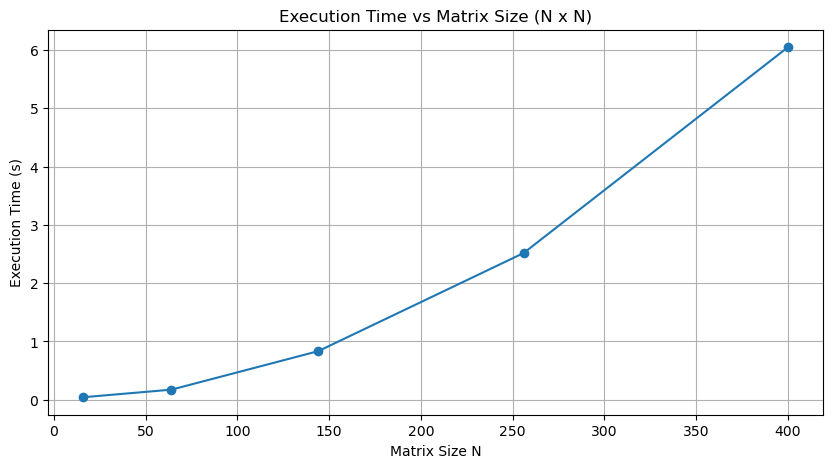

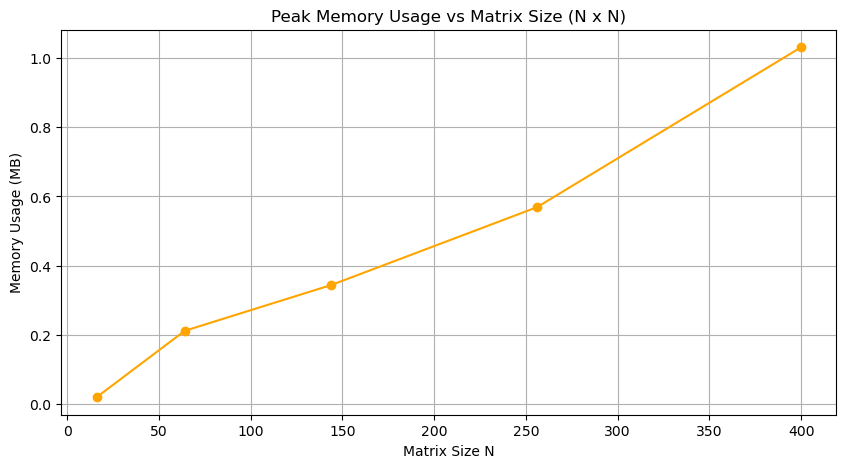

In [26]:
import trackhhl.toy.simple_generator as toy
import trackhhl.event_model.q_event_model as em
import numpy as np
import itertools
import time
from scipy.sparse import lil_matrix, block_diag
import tracemalloc
import matplotlib.pyplot as plt

# Constants
LX = float("+inf")
LY = float("+inf")
Z_SPACING = 1.0
params = {'alpha': 1.0, 'beta': 1.0, 'lambda': 100.0}

# Lists to store results
particle_counts = [2, 4, 6, 8, 10]  # Adjust this list as needed
matrix_sizes = []
execution_times = []
memory_usages = []

def generate_hamiltonian_optimized(event, params):
    lambda_val = params.get('lambda')
    alpha = params.get('alpha')
    beta = params.get('beta')

    modules = sorted(event.modules, key=lambda module: module.z)

    segments = [
        em.segment(from_hit, to_hit)
        for idx in range(len(modules) - 1)
        for from_hit, to_hit in itertools.product(modules[idx].hits, modules[idx + 1].hits)
    ]

    N = len(segments)

    # Initialize sparse block matrices for efficiency
    A_ang_blocks = []
    A_bif_blocks = []
    A_inh_blocks = []
    b = np.zeros(N)

    # Total Hamiltonian into smaller blocks for better memory management
    block_size = 500
    num_blocks = (N + block_size - 1) // block_size

    for block_idx in range(num_blocks):
        start_idx = block_idx * block_size
        end_idx = min(start_idx + block_size, N)

        # lil_matrix for each block
        A_ang_block = lil_matrix((end_idx - start_idx, end_idx - start_idx), dtype=np.float32)
        A_bif_block = lil_matrix((end_idx - start_idx, end_idx - start_idx), dtype=np.float32)
        A_inh_block = lil_matrix((end_idx - start_idx, end_idx - start_idx), dtype=np.float32)

        # Filling matrices
        for i in range(start_idx, end_idx):
            seg_i = segments[i]
            vect_i = seg_i.to_vect()
            norm_i = np.linalg.norm(vect_i)

            for j in range(i + 1, end_idx):
                seg_j = segments[j]
                vect_j = seg_j.to_vect()
                norm_j = np.linalg.norm(vect_j)

                cosine = np.dot(vect_i, vect_j) / (norm_i * norm_j)
                if np.abs(cosine - 1) < 1e-9:
                    A_ang_block[i - start_idx, j - start_idx] = 1
                    A_ang_block[j - start_idx, i - start_idx] = 1  # Symmetry

                if seg_i.from_hit == seg_j.from_hit and seg_i.to_hit != seg_j.to_hit:
                    A_bif_block[i - start_idx, j - start_idx] = -alpha
                    A_bif_block[j - start_idx, i - start_idx] = -alpha  # Symmetry

                if seg_i.from_hit != seg_j.from_hit and seg_i.to_hit == seg_j.to_hit:
                    A_bif_block[i - start_idx, j - start_idx] = -alpha
                    A_bif_block[j - start_idx, i - start_idx] = -alpha  # Symmetry

                s_ab = int(seg_i.from_hit.module_id == 1 and seg_j.to_hit.module_id == 1)
                if s_ab > 0:
                    A_inh_block[i - start_idx, j - start_idx] = beta * s_ab * s_ab
                    A_inh_block[j - start_idx, i - start_idx] = beta * s_ab * s_ab  # Symmetry

        A_ang_blocks.append(A_ang_block)
        A_bif_blocks.append(A_bif_block)
        A_inh_blocks.append(A_inh_block)

    # Combine with block diagonal
    A_ang = block_diag(A_ang_blocks, format='csc')
    A_bif = block_diag(A_bif_blocks, format='csc')
    A_inh = block_diag(A_inh_blocks, format='csc')

    A = -1 * (A_ang + A_bif + A_inh)

    return A, b, segments

# Main execution with try-except block
try:
    for N_PARTICLES in particle_counts:
        N_MODULES = 5  # Fixed number of modules
        detector = toy.SimpleDetectorGeometry(
            module_id=list(range(N_MODULES)),
            lx=[LX] * N_MODULES,
            ly=[LY] * N_MODULES,
            z=[i * Z_SPACING for i in range(N_MODULES)]
        )
        generator = toy.SimpleGenerator(
            detector_geometry=detector,
            theta_max=np.pi / 6
        )
        event = generator.generate_event(N_PARTICLES)

        # Performance measurement using tracemalloc
        tracemalloc.start()
        start_time = time.time()

        A, b, segments = generate_hamiltonian_optimized(event, params)

        end_time = time.time()
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()

        memory_used = peak / (1024 ** 2)  # Convert bytes to MB
        time_taken = end_time - start_time

        N = A.shape[0]  # Size of the Hamiltonian matrix

        matrix_sizes.append(N)
        execution_times.append(time_taken)
        memory_usages.append(memory_used)

        print(f"N_PARTICLES: {N_PARTICLES}, Matrix size: {N}x{N}, Time taken: {time_taken:.6f} s, Peak memory used: {memory_used:.2f} MB")

except Exception as e:
    # Handle exceptions during the loop
    print(f"An error occurred: {e}")
    # Stop collecting data
    pass  # The loop will exit due to the exception

finally:
    # Plot the data collected so far
    if execution_times and memory_usages:
        # Adjust matrix_sizes to match the length of collected data
        valid_matrix_sizes = matrix_sizes[:len(execution_times)]

        # Plotting Execution Time vs Matrix Size
        plt.figure(figsize=(10, 5))
        plt.plot(valid_matrix_sizes, execution_times, marker='o')
        plt.title('Execution Time vs Matrix Size (N x N)')
        plt.xlabel('Matrix Size N')
        plt.ylabel('Execution Time (s)')
        plt.grid(True)
        plt.show()

        # Plotting Memory Usage vs Matrix Size
        plt.figure(figsize=(10, 5))
        plt.plot(valid_matrix_sizes, memory_usages, marker='o', color='orange')
        plt.title('Peak Memory Usage vs Matrix Size (N x N)')
        plt.xlabel('Matrix Size N')
        plt.ylabel('Memory Usage (MB)')
        plt.grid(True)
        plt.show()
    else:
        print("No data collected to plot.")
